### Dataset creation

In [ ]:
'''
Install requirements
'''

!pip3 install -r requirements.txt
!pip3 install prettytable

In [2]:
'''
Imports external and own libraries
'''

import pickle

import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
from torch.utils.data import DataLoader

from prettytable import PrettyTable

# own
import collector
import action
import world
import plot
import preprocess
import nets
import train

/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/mariuskaestingschaefer/miniforge3/envs/pytorch/lib/python3.8/site-packages/torch/utils/tensorboard/__init__.py:6: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if not hasattr(tensorboard, '__version__') or LooseVersion(tensorboard.__version__) < LooseVersion('1.15'):


Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer


<Figure size 1440x396 with 0 Axes>

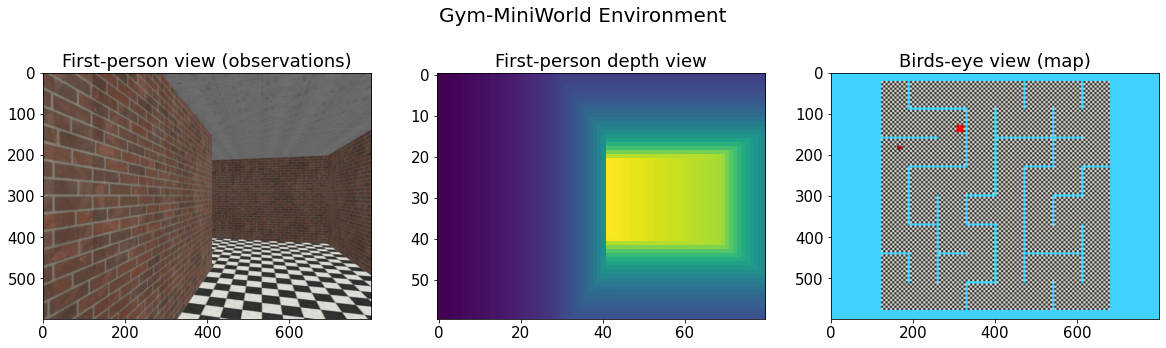

Agent variables
• current-pos: (2.16, 0.00, 7.49)
• current-angle: 14
• steps: 0
• observation-space: Box(0, 255, (60, 80, 3), uint8)
• action-space: Discrete(3)


In [3]:
'''
Create and visualize the world
'''
env = world.init_env('MiniWorld-Maze-v0')
plot.plot_obs_top_dep(env)
world.print_env_parameters(env)

In [ ]:
'''
(1) Create Oracle dataset
'''
oracle_actions = action.oracle_actions()
env = world.init_env('MiniWorld-Maze-v0')
oracle_data = collector.collect(oracle_actions, env, img_size=32, show=False)

with open('datasets/oracle_data.pickle', 'wb') as handle:
    pickle.dump(oracle_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

'''
(2) Create Oracle + reversed dataset
'''
oracle_actions = action.oracle_actions()
env = world.init_env('MiniWorld-Maze-v0')
reversed_actions = action.reverse_action_seq(oracle_actions)
oracle_reversed_data = collector.collect(oracle_actions + reversed_actions, env, img_size=32, show=False)

with open('datasets/oracle_reversed_data.pickle', 'wb') as handle:
    pickle.dump(oracle_reversed_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

'''
(3) Create Oracle dataset with random actions inbetween
'''
env = world.init_env('MiniWorld-Maze-v0')
oracle_random_actions = action.add_randomness(oracle_actions, env)
oracle_random_data = collector.collect(oracle_random_actions, env, img_size=32, show=False)

with open('datasets/oracle_random_data.pickle', 'wb') as handle:
    pickle.dump(oracle_random_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
'''
(4) Create Oracle dataset with random actions inbetween + reversed
'''
oracle_actions = action.oracle_actions()
env = world.init_env('MiniWorld-Maze-v0')
oracle_random_actions = action.add_randomness(oracle_actions, env)
reversed_actions = action.reverse_action_seq(oracle_random_actions)
oracle_reversed_random_data = collector.collect(oracle_random_actions + reversed_actions, env, img_size=32, show=False)

with open('datasets/oracle_reversed_random_data.pickle', 'wb') as handle:
    pickle.dump(oracle_reversed_random_data, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
'''
(5) Random dataset
'''
env = world.init_env('MiniWorld-Maze-v0')
random_act = action.random_actions(5000, env)
random_data = collector.collect(random_act, env, img_size=32, show=False)

with open('datasets/random_data.pickle', 'wb') as handle:
    pickle.dump(random_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [14]:
# (4) Create Oracle dataset with random actions inbetween + reversed

oracle_actions = action.oracle_actions()
env = world.init_env('MiniWorld-Maze-v0')
oracle_random_actions = action.add_randomness(oracle_actions[0:500], env, random_step_lenth=1)
print(len(oracle_random_actions))
reversed_actions = action.reverse_action_seq(oracle_random_actions)
oracle_reversed_random_data = collector.collect(oracle_random_actions + reversed_actions, env, img_size=32, show=False)

with open('datasets/oracle_reversed_random_data_small.pickle', 'wb') as handle:
    pickle.dump(oracle_reversed_random_data, handle, protocol=pickle.HIGHEST_PROTOCOL)


Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer
1500


Progress:   0%|          | 0/3000 [00:00<?, ? Steps/s]

In [15]:
def count_actions(data):
    count = []
    for i in set(data['actions']):
        count.append(data['actions'].count(i))
    return count

print(str(count_actions(oracle_reversed_random_data)))

[710, 710, 790, 790]


In [3]:
'''
Load data with pickle (deserialize)
'''
with open('datasets/oracle_data.pickle', 'rb') as handle:
    oracle_data = pickle.load(handle)

with open('datasets/oracle_reversed_data.pickle', 'rb') as handle:
    oracle_reversed_data = pickle.load(handle)

with open('datasets/oracle_random_data.pickle', 'rb') as handle:
    oracle_random_data = pickle.load(handle)

with open('datasets/oracle_reversed_random_data.pickle', 'rb') as handle:
    oracle_reversed_random_data = pickle.load(handle)
    
with open('datasets/random_data.pickle', 'rb') as handle:
    random_data = pickle.load(handle)

In [ ]:
print(random_data.keys())
plot.plot_3x3_examples(random_data)

In [ ]:
'''
Use Turtle to plot the agents trajectory. 
A gif making function
'''

oracle_actions = action.oracle_actions()
plot.turtle_tracing(oracle_actions)
plot.save_gif_of_sequence(oracle_actions)

In [4]:
'''
Compare different datasets
'''
def count_actions(data):
    count = []
    for i in set(data['actions']):
        count.append(data['actions'].count(i))
    return count

myTable = PrettyTable(["Dataset Name", "Length", "Distribution", "Environment"])
myTable.align["Dataset Name"] = "l"

# Add rows
myTable.add_row(["Oracle data", len(oracle_data['actions']), str(count_actions(oracle_data)), 'MiniWorld-Maze-v0'])
myTable.add_row(["Oracle data + reversed", len(oracle_reversed_data['actions']), str(count_actions(oracle_reversed_data)), 'MiniWorld-Maze-v0'])
myTable.add_row(["Oracle data + random", len(oracle_random_data['actions']), str(count_actions(oracle_random_data)), 'MiniWorld-Maze-v0'])
myTable.add_row(["Oracle data + random + reversed", len(oracle_reversed_random_data['actions']), str(count_actions(oracle_reversed_random_data)), 'MiniWorld-Maze-v0'])
myTable.add_row(["Random", len(random_data['actions']), str(count_actions(random_data)), 'MiniWorld-Maze-v0'])

print(myTable)

+---------------------------------+--------+--------------------------+-------------------+
| Dataset Name                    | Length |       Distribution       |    Environment    |
+---------------------------------+--------+--------------------------+-------------------+
| Oracle data                     |  1195  |      [90, 115, 990]      | MiniWorld-Maze-v0 |
| Oracle data + reversed          |  2390  |   [205, 205, 990, 990]   | MiniWorld-Maze-v0 |
| Oracle data + random            |  8365  | [2478, 2503, 2187, 1197] | MiniWorld-Maze-v0 |
| Oracle data + random + reversed | 16730  | [5041, 5041, 3324, 3324] | MiniWorld-Maze-v0 |
| Random                          |  5000  |    [1693, 1690, 1617]    | MiniWorld-Maze-v0 |
+---------------------------------+--------+--------------------------+-------------------+


Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer


<Figure size 1440x396 with 0 Axes>

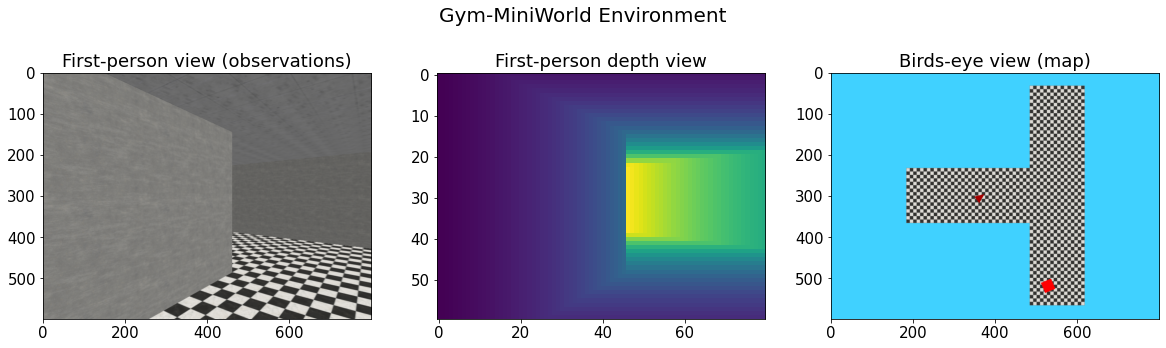

Agent variables
• current-pos: (4.37, 0.00, 0.14)
• current-angle: 37
• steps: 0
• observation-space: Box(0, 255, (60, 80, 3), uint8)
• action-space: Discrete(3)


In [63]:
env = world.init_env('MiniWorld-TMaze-v0')
plot.plot_obs_top_dep(env)
world.print_env_parameters(env)

<Figure size 1440x396 with 0 Axes>

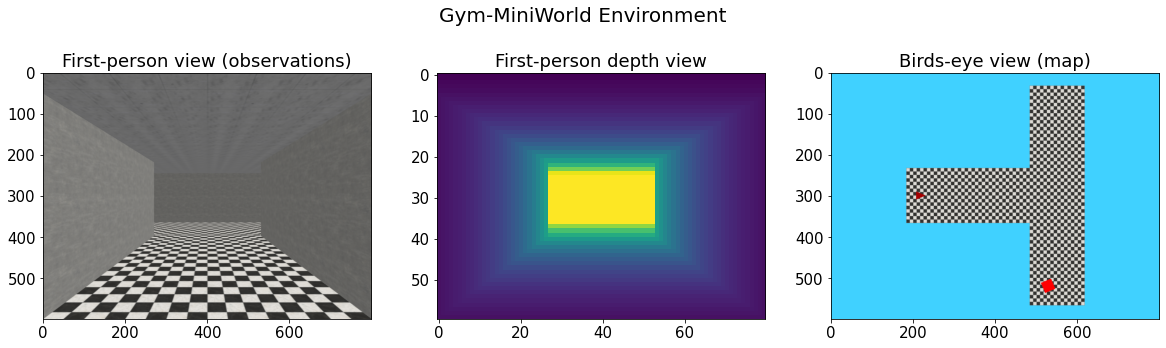

Agent variables
• current-pos: (0.00, 0.00, 0.00)
• current-angle: 0
• steps: 1211
• observation-space: Box(0, 255, (60, 80, 3), uint8)
• action-space: Discrete(3)


In [242]:
# can set up the agent manually
env.place_entity(env.agent, pos=[0, 0.0, 0])
env.agent.dir = 0
plot.plot_obs_top_dep(env)
world.print_env_parameters(env)

In [14]:
# How to create the dataset
# generate s random starting positions
# generate t random trajectories of length l

import random

amount_positions = 5
amount_trajectories = 100
length_trajectory = 5

action_sequences = []
for _ in range(amount_trajectories):
    seq = [random.randrange(0, 4, 1) for i in range(length_trajectory)]
    if seq not in action_sequences:
        action_sequences.append(seq)
        
positions = [[0, 0.0, 0]]
for _ in range(amount_positions):
    x = random.randrange(0, 110, 1)/10
    if x > 8.7:
        y = random.randrange(-74, 74, 1)/10
    else:
        y = random.randrange(-12, 15, 1)/10
    if [x, 0.0, y] not in positions:
        positions.append([x, 0.0, y])

env = world.init_env('MiniWorld-TMaze-v0')
for position in positions:
    for actions in action_sequences:
        env.place_entity(env.agent, pos=position)
        env.agent.dir = 0
        for action in actions:
            

Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer
[[0, 2, 3, 0, 2], [1, 0, 0, 0, 2], [1, 1, 1, 3, 2], [2, 3, 2, 0, 0], [2, 0, 2, 3, 0], [1, 0, 0, 0, 0], [1, 2, 2, 3, 3], [0, 1, 2, 0, 2], [0, 2, 0, 2, 1], [3, 1, 0, 1, 1], [3, 2, 3, 3, 2], [3, 3, 3, 0, 3], [2, 3, 3, 0, 3], [2, 1, 3, 2, 2], [0, 3, 1, 1, 0], [0, 2, 2, 1, 2], [2, 2, 3, 3, 0], [0, 2, 2, 0, 3], [2, 1, 3, 1, 2], [0, 0, 3, 1, 3], [1, 0, 0, 2, 2], [1, 3, 2, 1, 1], [3, 0, 3, 3, 3], [1, 0, 2, 2, 2], [2, 0, 3, 3, 2], [3, 3, 2, 2, 2], [2, 1, 3, 0, 2], [3, 3, 3, 3, 3], [2, 0, 0, 3, 1], [1, 2, 1, 1, 3], [3, 2, 3, 3, 1], [3, 1, 1, 1, 2], [3, 0, 2, 2, 0], [3, 1, 1, 3, 0], [0, 2, 0, 0, 3], [1, 2, 2, 0, 3], [2, 2, 1, 2, 0], [2, 3, 2, 1, 1], [0, 1, 2, 2, 0], [3, 2, 3, 3, 3], [1, 0, 1, 0, 0], [0, 0, 3, 2, 0], [3, 3, 0, 2, 3], [2, 3, 1, 1, 0], [3, 0, 2, 2, 1], [0, 2, 3, 0, 1], [3, 2, 2, 0, 1], [3, 3, 1, 0, 3], [2, 2, 0, 3, 1], [3, 1, 2, 3, 1

In [ ]:
import random

def collect2(env, amount_positions, amount_trajectories, length_trajectory, img_size=128, show=False,):
    '''
    Collect dataset containing actions, positions, angles, observations (first-
    person view), depth-view and the map.
    '''
    
    # generate random action sequences
    action_sequences = []
    for _ in range(amount_trajectories):
        seq = [random.randrange(0, 4, 1) for i in range(length_trajectory)]
        if seq not in action_sequences:
            action_sequences.append(seq)
    
    # generate random starting positions (within the T-maze)
    positions = [[0, 0.0, 0]]
    for _ in range(amount_positions):
        x = random.randrange(0, 110, 1)/10
        if x > 8.7:
            y = random.randrange(-74, 74, 1)/10
        else:
            y = random.randrange(-12, 15, 1)/10
        if [x, 0.0, y] not in positions:
            positions.append([x, 0.0, y])
            
    act_col = []
    pos_col = []
    angl_col = []
    obs_col = []
    top_col = []
    dep_col = []
    length_actions = len(actions)
    
    with tqdm(total=amount_positions*len(action_sequences), unit =" Steps", desc ="Progress") as pbar:
        for position in positions:
            for actions in action_sequences:
                env.place_entity(env.agent, pos=position)
                env.agent.dir = 0
                for action in actions:
                    _, _, _, _ = env.step(action)
                position = env.agent.pos # coordinates
                angle = int(env.agent.dir * 180 / math.pi) % 360

                observation = env.render('rgb_array')
                top_view = env.render('rgb_array', view='top') # map
                depth = env.render_depth()

                observation = resize(observation, (img_size, img_size))
                top_view = resize(top_view, (img_size, img_size))
                depth = resize(depth, (img_size, img_size))

                pos_col.append(position)
                angl_col.append(angle)
                obs_col.append(observation)
                top_col.append(top_view)
                dep_col.append(depth)

                pbar.update(1)   

In [ ]:
def collect2(env, length, amount_trajectories, length_trajectory, img_size=128, show=False,):
    '''
    Collect dataset containing actions, positions, angles, observations (first-
    person view), depth-view and the map.
    '''
    act_col = []
    pos_col = []
    angl_col = []
    obs_col = []
    top_col = []
    dep_col = []
    length_actions = len(actions)

    my_list = list(range(20))

    with tqdm(total=len(actions), unit =" Steps", desc ="Progress") as pbar:
        for i, action in enumerate(actions):
            _, _, _, _ = env.step(action)
            position = env.agent.pos # coordinates
            angle = int(env.agent.dir * 180 / math.pi) % 360

            observation = env.render('rgb_array')
            top_view = env.render('rgb_array', view='top') # map
            depth = env.render_depth()

            observation = resize(observation, (img_size, img_size))
            top_view = resize(top_view, (img_size, img_size))
            depth = resize(depth, (img_size, img_size))

            pos_col.append(position)
            angl_col.append(angle)
            obs_col.append(observation)
            top_col.append(top_view)
            dep_col.append(depth)

            pbar.update(1)

            if show and i > length_actions - 7: # print last n
                plot_obs_top_dep(env)
                print_env_parameters(env)

    dic={'actions':act_col, 'positions':pos_col, 'angles':angl_col,
        'observations':obs_col, 'top_views':top_col, 'depth_imgs':dep_col}

    return dic

In [ ]:
collect2(env, length=5, 100, 5)

<Figure size 1440x396 with 0 Axes>

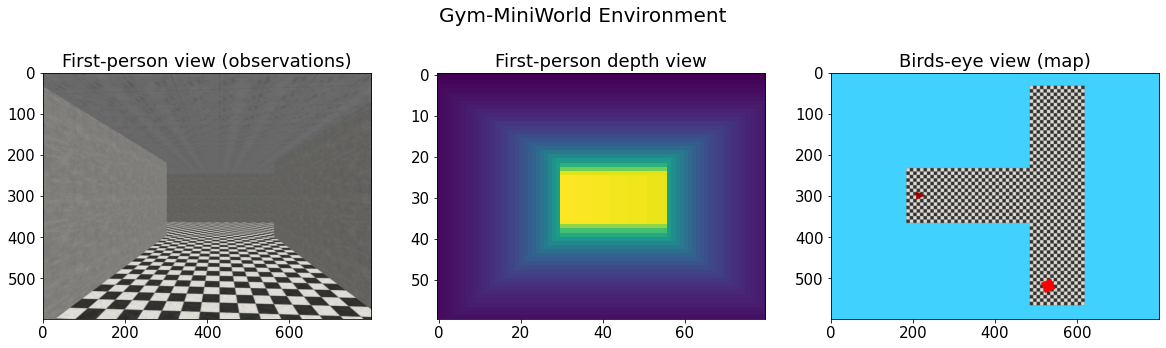

Agent variables
• current-pos: (0.00, 0.00, 0.00)
• current-angle: 3
• steps: 1211
• observation-space: Box(0, 255, (60, 80, 3), uint8)
• action-space: Discrete(3)
0.056479263296912385


In [240]:
for i in range(1):
    _, _, _, _ = env.step(0)
plot.plot_obs_top_dep(env)
world.print_env_parameters(env)
position = env.agent.pos # coordinates
print(env.agent.dir)

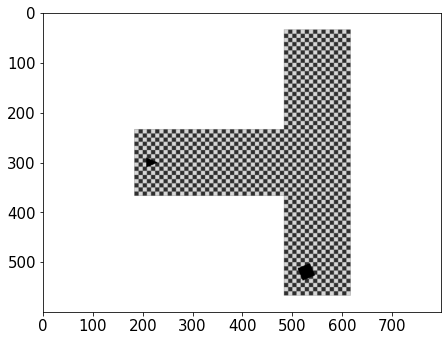

In [243]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

image = env.render('rgb_array', view='top')
arr = np.asarray(image)
plt.imshow(arr[:,:,2], cmap='gray')
plt.show()

In [19]:
import random

actions = []

for i in range(2000):
    actions.append(random.randint(0, 3))

env = world.init_env('MiniWorld-TMaze-v0')

tmaze_random_reverse_data = collector.collect(actions, env, img_size=32, show=False)

with open('datasets/tmaze_random_reverse_data.pickle', 'wb') as handle:
    pickle.dump(tmaze_random_reverse_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer


Progress:   0%|          | 0/2000 [00:00<?, ? Steps/s]

In [5]:
env = world.init_env('MiniWorld-TMaze-v0')
random_seq = action.random_actions(2000, env)

tmaze_random_data = collector.collect(random_seq, env, img_size=32, show=False)

with open('datasets/tmaze_random_data.pickle', 'wb') as handle:
    pickle.dump(tmaze_random_data, handle, protocol=pickle.HIGHEST_PROTOCOL)

Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer


Progress:   0%|          | 0/2000 [00:00<?, ? Steps/s]

In [20]:

def count_actions(data):
    count = []
    for i in set(data['actions']):
        count.append(data['actions'].count(i))
    return count

myTable = PrettyTable(["Dataset Name", "Length", "Distribution", "Environment"])
myTable.align["Dataset Name"] = "l"

# Add rows
myTable.add_row(["Random exporation forwards", len(tmaze_random_data['actions']), str(count_actions(tmaze_random_data)), 'MiniWorld-TMaze-v0'])
# Add rows
myTable.add_row(["Random exporation forwards+backwards", len(tmaze_random_reverse_data['actions']), str(count_actions(tmaze_random_reverse_data)), 'MiniWorld-TMaze-v0'])

print(myTable)

+--------------------------------------+--------+----------------------+--------------------+
| Dataset Name                         | Length |     Distribution     |    Environment     |
+--------------------------------------+--------+----------------------+--------------------+
| Random exporation forwards           |  2000  |   [677, 653, 670]    | MiniWorld-TMaze-v0 |
| Random exporation forwards+backwards |  2000  | [507, 485, 512, 496] | MiniWorld-TMaze-v0 |
+--------------------------------------+--------+----------------------+--------------------+


Falling back to num_samples=4
Falling back to non-multisampled frame buffer
Falling back to num_samples=4
Falling back to non-multisampled frame buffer


<Figure size 1440x396 with 0 Axes>

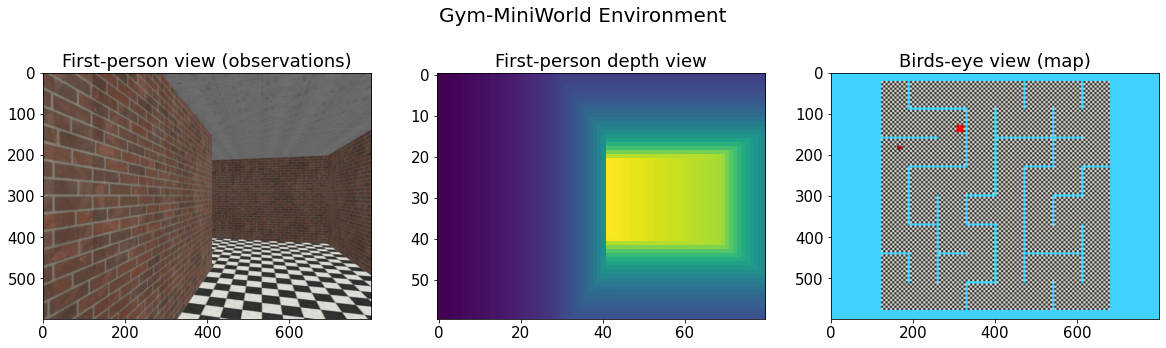

Agent variables
• current-pos: (2.16, 0.00, 7.49)
• current-angle: 14
• steps: 0
• observation-space: Box(0, 255, (60, 80, 3), uint8)
• action-space: Discrete(3)


In [41]:
env = world.init_env('MiniWorld-Maze-v0')
plot.plot_obs_top_dep(env)
world.print_env_parameters(env)

[ 2.04568879  0.         14.38446985]
270


<Figure size 1440x396 with 0 Axes>

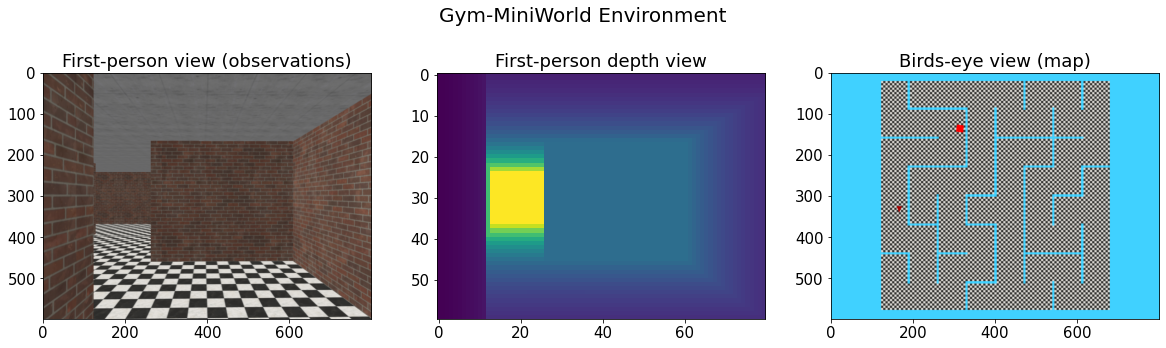

Agent variables
• current-pos: (2.05, 0.00, 14.38)
• current-angle: 270
• steps: 53
• observation-space: Box(0, 255, (60, 80, 3), uint8)
• action-space: Discrete(3)


In [52]:
import math

for i in range(15):
    _, _, _, _ = env.step(2)
    position = env.agent.pos # coordinates
    angle = int(env.agent.dir * 180 / math.pi) % 360

print(position)
print(angle)

plot.plot_obs_top_dep(env)
world.print_env_parameters(env)

In [25]:
oracle_actions = action.oracle_actions()
print(oracle_actions)

[1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 